In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pyproj
import os
import pandas as pd
import datetime
from shapely.geometry import Polygon
import cartopy.feature as cfeature
from shapely.ops import transform
from pyproj import Proj, transform as pyproj_transform
from cartopy.io.shapereader import Reader
import cartopy
import folium
from cartopy.feature import ShapelyFeature

In [ ]:
# In this script, I will:
#     1. Import data. I will refer to the IMD gridded data as "modelled", and the local meteorology station as "observed"
#     2. Extracting observation datapoints within the IMD gridded data
#     3. Match the "observed" datapoints to the "modelled" datapoints
#     4. Merge the matched datapoints and create unique scv for each pair of locations

In [ ]:
# 1. Importing data

In [3]:
# 1. 1. Imporing data on "modelled" stations

modelled_precip = pd.read_csv("data/clipped_raichur_rain.txt", delimiter=",")

# Get unique stations
# Drop duplicates to get unique locations
unique_locations_mod = modelled_precip[['lat', 'lon']].drop_duplicates()

# View the unique locations
unique_locations_mod

          lat    lon
0       16.25  76.50
45291   16.25  76.75
90582   16.25  77.00
135873  16.50  76.50
181164  16.50  76.75
226455  16.50  77.00


In [15]:
# 1. 2. Importing data on observed stations
observed_precip = pd.read_csv("data/Observed station _daily_rainfall_raichur.csv",  skiprows=3, delimiter=",")

# Clean LAT and LON columns
# The format of the input data was weird, this fixes it
observed_precip['LAT'] = observed_precip['LAT'].str.replace(' DEG.', '', regex=False).astype(float)
observed_precip['LON'] = observed_precip['LON'].str.replace(' DEG. E', '', regex=False).astype(float)

# Get unique stations. This is for easy plotting later and to get familiar with the locations. 
unique_stations_obs = observed_precip[['STATION', 'LAT', 'LON']].drop_duplicates()
unique_stations_obs

,STATION,LAT,LON
0,ARAKERE,16.2667,76.8500
1,ARAKERE,16.1333,76.8833
2,ARAKERE,16.1667,77.0333
18477,DEODURGA,16.4167,76.9167
27145,DEOSUGAR,16.3667,77.3667
31716,GABBUR,16.3167,77.1667
39046,HATTI CAMP,16.2000,76.6333
44766,JALAHALLI,16.3667,76.8667
52751,KAVITAL,16.1167,76.8000
59121,LINGASUGUR T.O.,16.1667,76.5167


In [ ]:
# 1.3. Define corner coordinates for the area covered by IMD gridbox
# This will be used for plotting (1.4.) and masking (2.1)
lat_min, lon_min = 16.125 , 76.375   # Bottom-left
lat_max, lon_max = 16.625, 77.125   # Top-right

Text(0, 0.5, 'Latitude')

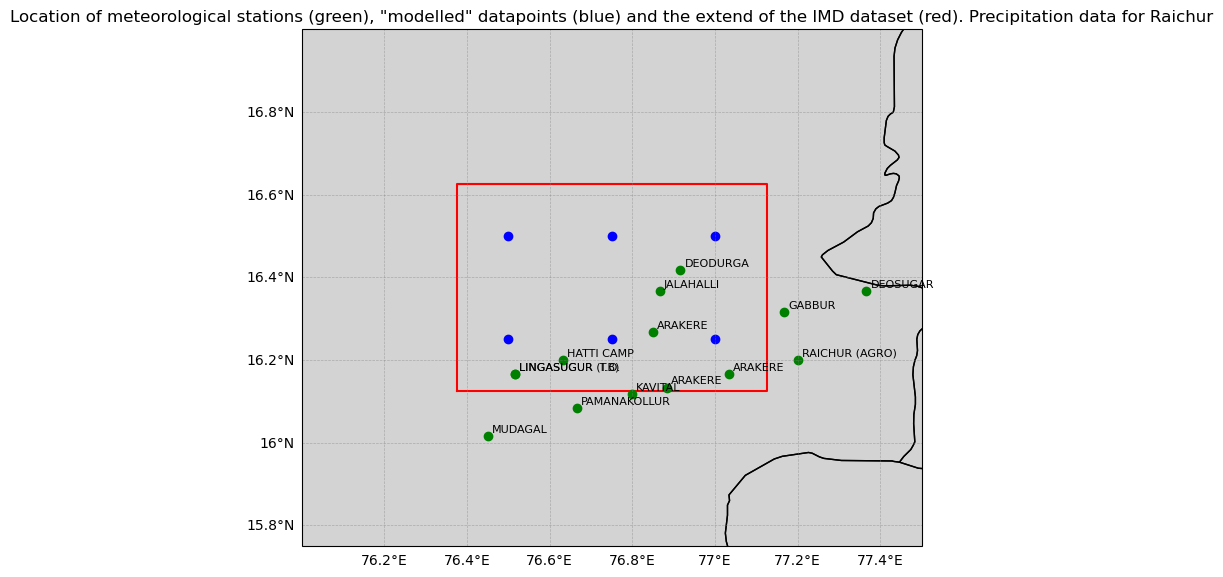

In [39]:
# 1. 4. Visualizing loaded data
# Map of observation stations
# Create the figure with a map projection

###############################################################
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add natural features (land, coastlines, states)
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black')

# Set the map extent to focus around the Raichur area, but a bit outside of the gridbox for Raichur from the shapefile
ax.set_extent([76, 77.5, 15.75, 17])  # [west, east, south, north]
###############################################################

###############################################################
# Drawing the rectangle that captures the area in the IMD dataset (6 grid cells that cover Raichur) (Values in the 1.3. point above)
rec_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
rec_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax.plot(rec_lons, rec_lats, color='red', markersize=6, transform=ccrs.PlateCarree())
###############################################################

# Plotting observation stations
# I already have unique stations
for _, row in unique_stations_obs.iterrows():
    ax.plot(row['LON'], row['LAT'], marker='o', color='green', markersize=6, transform=ccrs.PlateCarree())
    ax.text(row['LON'] + 0.01, row['LAT'] + 0.01, row['STATION'], fontsize=8, transform=ccrs.PlateCarree())

ax.plot(unique_locations_mod['lon'], unique_locations_mod['lat'], 'o', color='blue', markersize=6, transform=ccrs.PlateCarree())
###############################################################

###############################################################
# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
plt.title('Location of meteorological stations (green), "modelled" datapoints (blue) and the extend of the IMD dataset (red). Precipitation data for Raichur', fontsize = 12)

# Axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
###############################################################

In [41]:
unique_stations_obs

,STATION,LAT,LON
0,ARAKERE,16.2667,76.8500
1,ARAKERE,16.1333,76.8833
2,ARAKERE,16.1667,77.0333
18477,DEODURGA,16.4167,76.9167
27145,DEOSUGAR,16.3667,77.3667
31716,GABBUR,16.3167,77.1667
39046,HATTI CAMP,16.2000,76.6333
44766,JALAHALLI,16.3667,76.8667
52751,KAVITAL,16.1167,76.8000
59121,LINGASUGUR T.O.,16.1667,76.5167


In [43]:
# 2.1. Masking for the unique stations within my grid

# This will give me an array with true/false values. If true, the station is within the grid. If false, it is outside of the grid
# Here I mask only for the unique stations. This is just to identify the stations in grid, 
# and check, if their number is correct (there are 8 so it looks good)

masked_stations = ((lat_min <= unique_stations_obs['LAT']) &  (unique_stations_obs['LAT'] <= lat_max) 
 & (lon_min <= unique_stations_obs['LON']) &  (unique_stations_obs['LON'] <= lon_max))
masked_stations

0         True
1         True
2         True
18477     True
27145    False
31716    False
39046     True
44766     True
52751    False
59121     True
64506     True
69589    False
78021    False
84139    False
dtype: bool

In [47]:
# 2.2. Here I mask for all of the stations. This will be used to create the full datasets later
masked_obs = ((lat_min <= observed_precip['LAT']) &  (observed_precip['LAT'] <= lat_max) 
 & (lon_min <= observed_precip['LON']) &  (observed_precip['LON'] <= lon_max))
masked_obs

0         True
1         True
2         True
3         True
4         True
         ...  
85860    False
85861    False
85862    False
85863    False
85864    False
Length: 85865, dtype: bool

In [49]:
# 2.3 This gives me a masked dataset (only for locations withing the IMD grid) with all information preserved (date, precipitation ect.)
observed_stations_in_grid = observed_precip[masked_obs]
observed_stations_in_grid 

,STATION,DISTRICT,LAT,LON,YEAR,MONTH,DAY,DATE,RAINFALL
0,ARAKERE,RAICHUR,16.2667,76.8500,2000,1,1,01/01/2000,0.0
1,ARAKERE,RAICHUR,16.1333,76.8833,2000,1,1,01/01/2000,0.0
2,ARAKERE,RAICHUR,16.1667,77.0333,2000,1,1,01/01/2000,0.0
3,ARAKERE,RAICHUR,16.2667,76.8500,2000,1,2,02/01/2000,0.0
4,ARAKERE,RAICHUR,16.1333,76.8833,2000,1,2,02/01/2000,0.0
...,...,...,...,...,...,...,...,...,...
69584,LINGASUGUR (I.B),RAICHUR,16.1667,76.5167,2016,12,27,27/12/2016,0.0
69585,LINGASUGUR (I.B),RAICHUR,16.1667,76.5167,2016,12,28,28/12/2016,0.0
69586,LINGASUGUR (I.B),RAICHUR,16.1667,76.5167,2016,12,29,29/12/2016,0.0
69587,LINGASUGUR (I.B),RAICHUR,16.1667,76.5167,2016,12,30,30/12/2016,0.0


In [51]:
# 2.4 Here I'm taking a look at the names of the unque moasked stations
stations_obs_masked = unique_stations_obs[masked_stations]['STATION']
stations_obs_masked

0                 ARAKERE
1                 ARAKERE
2                 ARAKERE
18477            DEODURGA
39046          HATTI CAMP
44766           JALAHALLI
59121    LINGASUGUR  T.O.
64506    LINGASUGUR (I.B)
Name: STATION, dtype: object

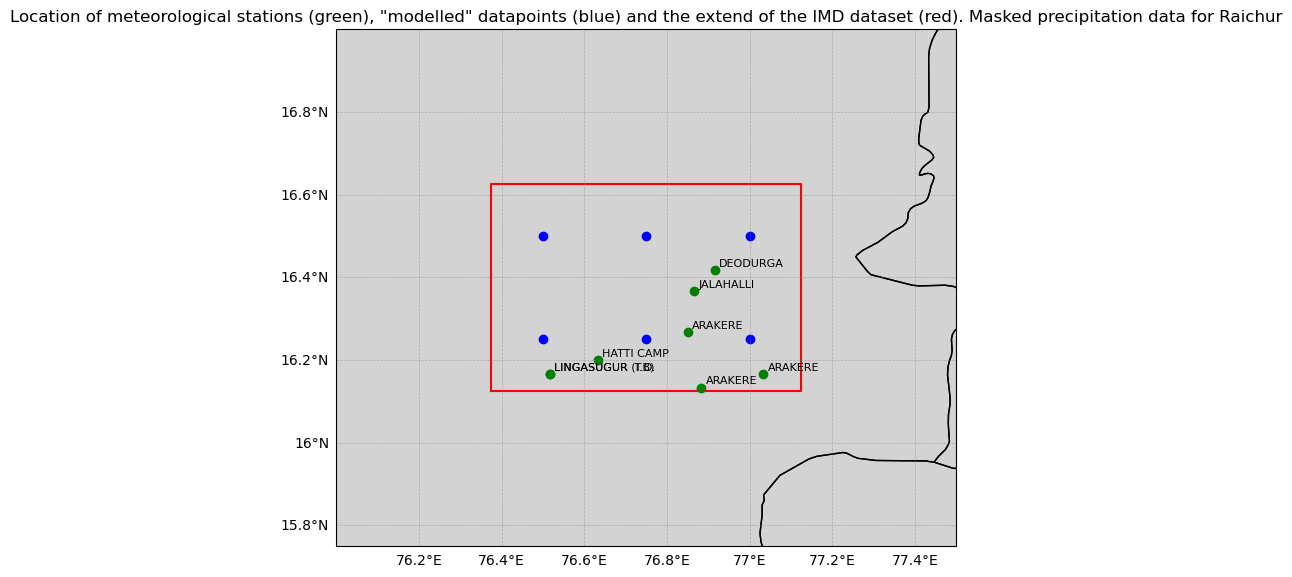

In [57]:
# 2.5. Map of masked observation stations
###############################################################
# Create the figure with a map projection
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add natural features (land, coastlines, states)
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black')

###############################################################
# Set the map extent to focus around the Raichur area, but a bit outside of the gridbox for Raichur from the shapefile
ax.set_extent([76, 77.5, 15.75, 17])  # [west, east, south, north]

###############################################################
# Drawing the rectangle that captures the area in the IMD dataset (6 grid cells that cover Raichur) (Values in the 1.3. point above)
rec_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
rec_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax.plot(rec_lons, rec_lats, color='red', markersize=6, transform=ccrs.PlateCarree())

###############################################################
# Plotting observation stations
# I already have unique stations
for _, row in unique_stations_obs[masked_stations].iterrows():
    ax.plot(row['LON'], row['LAT'], marker='o', color='green', markersize=6, transform=ccrs.PlateCarree())
    ax.text(row['LON'] + 0.01, row['LAT'] + 0.01, row['STATION'], fontsize=8, transform=ccrs.PlateCarree())

ax.plot(unique_locations_mod['lon'], unique_locations_mod['lat'], 'o', color='blue', markersize=6, transform=ccrs.PlateCarree())
###############################################################

###############################################################
# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Title
plt.title('Location of meteorological stations (green), "modelled" datapoints (blue) and the extend of the IMD dataset (red). Masked precipitation data for Raichur')

# Axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()
###############################################################

In [61]:
# 2.6. Here I found the first issue, there are two stations, witht he exact same locations (LINGASUGUR T.O., LINGASUGUR (I.B))
unique_stations_obs_in_grid = unique_stations_obs[masked_stations]
unique_stations_obs_in_grid 

,STATION,LAT,LON
0,ARAKERE,16.2667,76.8500
1,ARAKERE,16.1333,76.8833
2,ARAKERE,16.1667,77.0333
18477,DEODURGA,16.4167,76.9167
39046,HATTI CAMP,16.2000,76.6333
44766,JALAHALLI,16.3667,76.8667
59121,LINGASUGUR T.O.,16.1667,76.5167
64506,LINGASUGUR (I.B),16.1667,76.5167


In [63]:
# station_name = sorted(set(observed_precip['STATION']))[7]
# station_name

'LINGASUGUR  T.O.'

In [ ]:
# mask_ib.sum()

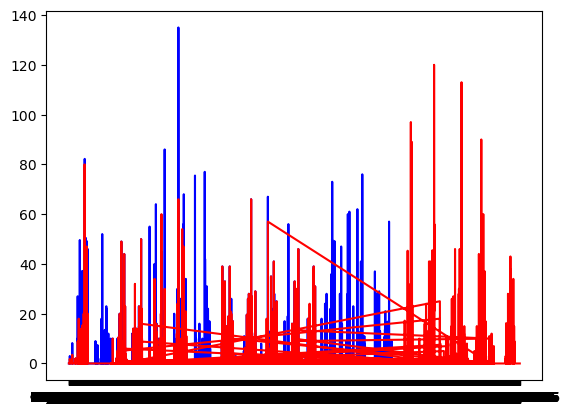

In [67]:
# mask_to = observed_precip['STATION'] ==  station_name
# mask_ib = observed_precip['STATION'] == 'LINGASUGUR (I.B)'

# plt.plot(observed_precip['DATE'][mask_to], observed_precip['RAINFALL'][mask_to], color = "blue")
# plt.plot(observed_precip['DATE'][mask_ib], observed_precip['RAINFALL'][mask_ib], color = "red")

In [65]:
# 3.1. calculating the distance from "observed" to "modelled" datapoints (in this order). 
for _, row in unique_stations_obs_in_grid.iterrows():
    dist2 = ((unique_locations_mod['lat'].values - row['LAT'])**2 + 
    (unique_locations_mod['lon'].values - row['LON'])**2) # Here I calculate the distance of every masked observation station to every "modelled" gridpoint (blue dots in the drawings)
    min = np.argmin(dist2) # This finds the smallest distance
    print(min) # This prints, which "modelled" gridpoint is closest to the observation station (counting is from 0!)
    print(dist2) # Printing the distances, just to make sure they are calculated correctly
    

1
[0.12277889 0.01027889 0.02277889 0.17692889 0.06442889 0.07692889]
2
[0.16053778 0.03138778 0.02723778 0.28138778 0.15223778 0.14808778]
2
[0.29134778 0.08719778 0.00804778 0.39549778 0.19134778 0.11219778]
5
[0.20142778 0.05557778 0.03472778 0.18057778 0.03472778 0.01387778]
1
[0.02026889 0.01611889 0.13696889 0.10776889 0.10361889 0.22446889]
1
[0.14808778 0.02723778 0.03138778 0.15223778 0.03138778 0.03553778]
0
[0.00721778 0.06136778 0.24051778 0.11136778 0.16551778 0.34466778]
0
[0.00721778 0.06136778 0.24051778 0.11136778 0.16551778 0.34466778]


In [ ]:
# 3.2. I looked up the coordinates of the unique_stations_obs_in_grid and unique_locations_mod. 
# I matched the coordinates in two points manually, based on the min() in 3.1
# So, the pairs are:
#        obs                         |      model
# ARAKERE 	      16.2667 	76.8500  | 16.25 	76.75 (1)
# ARAKERE 	      16.1333 	76.8833  | 16.25 	77.00 (2)
# ARAKERE 	      16.1667 	77.0333  | 16.25 	77.00 (2) 
# DEODURGA 	      16.4167 	76.9167  | 16.50 	77.00 (5)
# HATTI CAMP      16.2000 	76.6333  | 16.25 	76.75 (1)
# JALAHALLI       16.3667 	76.8667  | 16.25 	76.75 (1) 
# LINGASUGUR T.O. 16.1667 	76.5167  | 16.25 	76.50 (0)
# LINGASUGUR(I.B) 16.1667 	76.5167  | 16.25 	76.50 (0)

In [ ]:
# Adding date time so I can merge the dataframes

In [69]:
# 4.1. Convert DATE column to datetime in observed
observed_stations_in_grid['DATE'] = pd.to_datetime(observed_stations_in_grid['DATE'], dayfirst=True)
observed_stations_in_grid['DATE']

C:\Users\48512\AppData\Local\Temp\ipykernel_17292\1653629249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed_stations_in_grid['DATE'] = pd.to_datetime(observed_stations_in_grid['DATE'], dayfirst=True)


0       2000-01-01
1       2000-01-01
2       2000-01-01
3       2000-01-02
4       2000-01-02
           ...    
69584   2016-12-27
69585   2016-12-28
69586   2016-12-29
69587   2016-12-30
69588   2016-12-31
Name: DATE, Length: 51318, dtype: datetime64[ns]

In [71]:
# 4.2. Convert 'time' to datetime in "modelled" (IMD)
modelled_precip['DATE'] = pd.to_datetime(modelled_precip['time'])
modelled_precip['DATE']

0        1901-01-01
1        1901-01-02
2        1901-01-03
3        1901-01-04
4        1901-01-05
            ...    
271741   2024-12-27
271742   2024-12-28
271743   2024-12-29
271744   2024-12-30
271745   2024-12-31
Name: DATE, Length: 271746, dtype: datetime64[ns]

In [ ]:
# 4.3. Here I manually made the scv for each location pairs

In [ ]:
#        obs                         |      model
# ARAKERE 	      16.2667 	76.8500  | 16.25 	76.75

# Obs
ARAKERE_16_2667_76_8500 = observed_stations_in_grid[
    (observed_stations_in_grid['LAT'] == 16.2667) &
    (observed_stations_in_grid['LON'] == 76.8500)
].copy()
ARAKERE_16_2667_76_8500

# Model
mod_16_25_76_75 = modelled_precip[
    (modelled_precip['lat'] == 16.25) &
    (modelled_precip['lon'] == 76.75)
].copy()

# Merge the two on datetime
ARAKERE_16_2667_76_8500_merged = pd.merge(
    ARAKERE_16_2667_76_8500[['DATE', 'RAINFALL']],
    mod_16_25_76_75[['DATE', 'rain']],
    left_on='DATE',
    right_on='DATE',
    how='inner'  # or 'outer' if you want all dates
)

# Clean up column names
ARAKERE_16_2667_76_8500_merged = ARAKERE_16_2667_76_8500_merged.rename(columns={
    'RAINFALL': 'observed_rainfall',
    'rain': 'modelled_rainfall'})

ARAKERE_16_2667_76_8500_merged

# saving the dataframe
ARAKERE_16_2667_76_8500_merged.to_csv(r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Design of climate change mitigation and adaptation strategies\Data\merged_data_precip\ARAKERE_16_2667_76_8500_merged.csv')
ARAKERE_16_2667_76_8500_merged['observed_rainfall'].sum() # Checking if the df is not empty



In [ ]:
#        obs                         |      model
# ARAKERE 	      16.1333 	76.8833  | 16.25 	77.00

# Obs
ARAKERE_16_1333_76_8833 = observed_stations_in_grid[
    (observed_stations_in_grid['LAT'] == 16.1333) &
    (observed_stations_in_grid['LON'] == 76.8833)
].copy()
ARAKERE_16_1333_76_8833

# Model
mod_16_25_77_00 = modelled_precip[
    (modelled_precip['lat'] == 16.25) &
    (modelled_precip['lon'] == 77.00)
].copy()

# Merge the two on datetime
ARAKERE_16_1333_76_8833_merged = pd.merge(
    ARAKERE_16_1333_76_8833[['DATE', 'RAINFALL']],
    mod_16_25_77_00[['DATE', 'rain']],
    left_on='DATE',
    right_on='DATE',
    how='inner'  # or 'outer' if you want all dates
)

# Clean up column names
ARAKERE_16_1333_76_8833_merged = ARAKERE_16_1333_76_8833_merged.rename(columns={
    'RAINFALL': 'observed_rainfall',
    'rain': 'modelled_rainfall'})

ARAKERE_16_1333_76_8833_merged

# saving the dataframe
ARAKERE_16_1333_76_8833_merged.to_csv(r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Design of climate change mitigation and adaptation strategies\Data\merged_data_precip\ARAKERE_16_1333_76_8833_merged.csv')



In [ ]:
#        obs                         |      model
# ARAKERE 	      16.1667 	77.0333  | 16.25 	77.00

# Obs
ARAKERE_16_1333_77_0333 = observed_stations_in_grid[
    (observed_stations_in_grid['LAT'] == 16.1667) &
    (observed_stations_in_grid['LON'] == 77.0333)
].copy()
ARAKERE_16_1333_77_0333

# Model
mod_16_25_77_00 = modelled_precip[
    (modelled_precip['lat'] == 16.25) &
    (modelled_precip['lon'] == 77.00)
].copy()

# Merge the two on datetime
ARAKERE_16_1333_77_0333_merged = pd.merge(
    ARAKERE_16_1333_77_0333[['DATE', 'RAINFALL']],
    mod_16_25_77_00[['DATE', 'rain']],
    left_on='DATE',
    right_on='DATE',
    how='inner'  # or 'outer' if you want all dates
)

# Clean up column names
ARAKERE_16_1333_77_0333_merged = ARAKERE_16_1333_77_0333_merged.rename(columns={
    'RAINFALL': 'observed_rainfall',
    'rain': 'modelled_rainfall'})



# saving the dataframe
ARAKERE_16_1333_77_0333_merged.to_csv(r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Design of climate change mitigation and adaptation strategies\Data\merged_data_precip\ARAKERE_16_1667_77_0333_merged.csv')



In [ ]:
#        obs                         |      model
# DEODURGA 	      16.4167 	76.9167  | 16.50 	77.00

# Obs
DEODURGA_16_4167_79_9167 = observed_stations_in_grid[
    (observed_stations_in_grid['LAT'] == 16.4167) &
    (observed_stations_in_grid['LON'] == 76.9167)
].copy()
DEODURGA_16_4167_79_9167

# Model
mod_16_50_77_00 = modelled_precip[
    (modelled_precip['lat'] == 16.50) &
    (modelled_precip['lon'] == 77.00)
].copy()

# Merge the two on datetime
DEODURGA_16_4167_79_9167_merged = pd.merge(
    DEODURGA_16_4167_79_9167[['DATE', 'RAINFALL']],
    mod_16_50_77_00[['DATE', 'rain']],
    left_on='DATE',
    right_on='DATE',
    how='inner'  # or 'outer' if you want all dates
)

# Clean up column names
DEODURGA_16_4167_79_9167_merged = DEODURGA_16_4167_79_9167_merged.rename(columns={
    'RAINFALL': 'observed_rainfall',
    'rain': 'modelled_rainfall'})



# saving the dataframe
DEODURGA_16_4167_79_9167_merged.to_csv(r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Design of climate change mitigation and adaptation strategies\Data\merged_data_precip\DEODURGA_16_4167_79_9167_merged.csv')



In [ ]:
#        obs                         |      model
# HATTI CAMP      16.2000 	76.6333  | 16.25 	76.75

# Obs
HATTICAMP_16_2000_76_6333 = observed_stations_in_grid[
    (observed_stations_in_grid['LAT'] == 16.2000) &
    (observed_stations_in_grid['LON'] == 76.6333)
].copy()
HATTICAMP_16_2000_76_6333

# Model
mod_16_25_76_75 = modelled_precip[
    (modelled_precip['lat'] == 16.25) &
    (modelled_precip['lon'] == 76.75)
].copy()

# Merge the two on datetime
HATTICAMP_16_2000_76_6333_merged = pd.merge(
    HATTICAMP_16_2000_76_6333[['DATE', 'RAINFALL']],
    mod_16_25_76_75[['DATE', 'rain']],
    left_on='DATE',
    right_on='DATE',
    how='inner'  # or 'outer' if you want all dates
)

# Clean up column names
HATTICAMP_16_2000_76_6333_merged = HATTICAMP_16_2000_76_6333_merged.rename(columns={
    'RAINFALL': 'observed_rainfall',
    'rain': 'modelled_rainfall'})



# saving the dataframe
HATTICAMP_16_2000_76_6333_merged.to_csv(r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Design of climate change mitigation and adaptation strategies\Data\merged_data_precip\HATTICAMP_16_2000_76_6333_merged.csv')


In [ ]:
#        obs                         |      model
# JALAHALLI       16.3667 	76.8667  | 16.25 	76.75

# Obs
JALAHALLI_16_3667_76_8667 = observed_stations_in_grid[
    (observed_stations_in_grid['LAT'] == 16.3667) &
    (observed_stations_in_grid['LON'] == 76.8667)
].copy()
JALAHALLI_16_3667_76_8667

# Model
mod_16_25_76_75 = modelled_precip[
    (modelled_precip['lat'] == 16.25) &
    (modelled_precip['lon'] == 76.75)
].copy()

# Merge the two on datetime
JALAHALLI_16_3667_76_8667_merged = pd.merge(
    JALAHALLI_16_3667_76_8667[['DATE', 'RAINFALL']],
    mod_16_25_76_75[['DATE', 'rain']],
    left_on='DATE',
    right_on='DATE',
    how='inner' 
)

# Clean up column names
JALAHALLI_16_3667_76_8667_merged = JALAHALLI_16_3667_76_8667_merged.rename(columns={
    'RAINFALL': 'observed_rainfall',
    'rain': 'modelled_rainfall'})



# saving the dataframe
JALAHALLI_16_3667_76_8667_merged.to_csv(r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Design of climate change mitigation and adaptation strategies\Data\merged_data_precip\JALAHALLI_16_3667_76_8667_merged.csv')


In [ ]:
#        obs                         |      model
# JALAHALLI       16.3667 	76.8667  | 16.25 	76.75

# Obs
JALAHALLI_16_3667_76_8667 = observed_stations_in_grid[
    (observed_stations_in_grid['LAT'] == 16.3667) &
    (observed_stations_in_grid['LON'] == 76.8667)
].copy()
JALAHALLI_16_3667_76_8667

# Model
mod_16_25_76_75 = modelled_precip[
    (modelled_precip['lat'] == 16.25) &
    (modelled_precip['lon'] == 76.75)
].copy()

# Merge the two on datetime
JALAHALLI_16_3667_76_8667_merged = pd.merge(
    JALAHALLI_16_3667_76_8667[['DATE', 'RAINFALL']],
    mod_16_25_76_75[['DATE', 'rain']],
    left_on='DATE',
    right_on='DATE',
    how='inner' 
)

# Clean up column names
JALAHALLI_16_3667_76_8667_merged = JALAHALLI_16_3667_76_8667_merged.rename(columns={
    'RAINFALL': 'observed_rainfall',
    'rain': 'modelled_rainfall'})



# saving the dataframe
JALAHALLI_16_3667_76_8667_merged.to_csv(r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Design of climate change mitigation and adaptation strategies\Data\merged_data_precip\JALAHALLI_16_3667_76_8667_merged.csv')


In [ ]:
observed_stations_in_grid

In [ ]:
#        obs                         |      model
# LINGASUGUR T.O. 16.1667 	76.5167  | 16.25 	76.50

# Obs
LINGASUGUR_TO_16_1667_76_5167 = observed_stations_in_grid[
    (observed_stations_in_grid['LAT'] == 16.1667) &
    (observed_stations_in_grid['LON'] == 76.5167) &
    (observed_stations_in_grid['STATION'] != 'LINGASUGUR (I.B)')
].copy()
LINGASUGUR_TO_16_1667_76_5167

# Model
mod_16_25_76_50 = modelled_precip[
    (modelled_precip['lat'] == 16.25) &
    (modelled_precip['lon'] == 76.50)
].copy()

# Merge the two on datetime
LINGASUGUR_TO_16_1667_76_5167_merged = pd.merge(
    LINGASUGUR_TO_16_1667_76_5167[['DATE', 'RAINFALL']],
    mod_16_25_76_50[['DATE', 'rain']],
    left_on='DATE',
    right_on='DATE',
    how='inner' 
)

# Clean up column names
LINGASUGUR_TO_16_1667_76_5167_merged = LINGASUGUR_TO_16_1667_76_5167_merged.rename(columns={
    'RAINFALL': 'observed_rainfall',
    'rain': 'modelled_rainfall'})



# saving the dataframe
LINGASUGUR_TO_16_1667_76_5167_merged.to_csv(r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Design of climate change mitigation and adaptation strategies\Data\merged_data_precip\LINGASUGUR_TO_16_1667_76_5167_merged.csv')


In [ ]:
LINGASUGUR_TO_16_1667_76_5167

In [ ]:
#        obs                         |      model
# LINGASUGUR(I.B) 16.1667 	76.5167  | 16.25 	76.50

# Obs
LINGASUGUR_IB_16_1667_76_5167 = observed_stations_in_grid[
    (observed_stations_in_grid['LAT'] == 16.1667) &
    (observed_stations_in_grid['LON'] == 76.5167) &
    (observed_stations_in_grid['STATION'] == 'LINGASUGUR (I.B)')
].copy()
LINGASUGUR_IB_16_1667_76_5167

# Model
mod_16_25_76_50 = modelled_precip[
    (modelled_precip['lat'] == 16.25) &
    (modelled_precip['lon'] == 76.50)
].copy()

# Merge the two on datetime
LINGASUGUR_IB_16_1667_76_5167_merged = pd.merge(
    LINGASUGUR_IB_16_1667_76_5167[['DATE', 'RAINFALL']],
    mod_16_25_76_50[['DATE', 'rain']],
    left_on='DATE',
    right_on='DATE',
    how='inner' 
)

# Clean up column names
LINGASUGUR_IB_16_1667_76_5167_merged = LINGASUGUR_IB_16_1667_76_5167_merged.rename(columns={
    'RAINFALL': 'observed_rainfall',
    'rain': 'modelled_rainfall'})



# saving the dataframe
LINGASUGUR_IB_16_1667_76_5167_merged.to_csv(r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Design of climate change mitigation and adaptation strategies\Data\merged_data_precip\LINGASUGUR_IB_16_1667_76_5167_merged.csv')


In [73]:
# testing plotting
plt.plot(LINGASUGUR_IB_16_1667_76_5167_merged['DATE'], LINGASUGUR_IB_16_1667_76_5167_merged['modelled_rainfall'], color = "blue", label = "IB")
plt.plot(LINGASUGUR_TO_16_1667_76_5167_merged['DATE'], LINGASUGUR_TO_16_1667_76_5167_merged['modelled_rainfall'], color = "red", label = "TO" )
plt.legend()
plt.title('Precipitation atht he two LINGASUGUR stations. Why different if same location?')

NameError: name 'LINGASUGUR_IB_16_1667_76_5167_merged' is not defined

In [ ]:
plt.plot(JALAHALLI_16_3667_76_8667_merged['DATE'], JALAHALLI_16_3667_76_8667_merged['modelled_rainfall'], color = "blue", label = "Modelled")
plt.plot(JALAHALLI_16_3667_76_8667_merged['DATE'], JALAHALLI_16_3667_76_8667_merged['observed_rainfall'], color = "red", label = "Observed" )
plt.legend()
correlation = JALAHALLI_16_3667_76_8667_merged['modelled_rainfall'].corr(JALAHALLI_16_3667_76_8667_merged['observed_rainfall'])
plt.title('Modelled and observed precipitaton [mm]. JALAHALLI. Correlation = 0.67')
print(correlation)